In [145]:
import torch
from torch.backends import cudnn
from torch import nn
import torchvision  # 图片、视频处理
from torchvision.transforms import ToTensor
import torch.nn.functional as F  # 避免relu和sigmoid的初始化，可以直接调用

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split    


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, random
# %matplotlib inline
# vTest = 1000

from importlib import reload 
from qflib import basic
reload(basic)
global engine, conn
engine = basic.engine()
conn = basic.conn(engine)

device = 'cuda' if torch.cuda.is_available else 'cpu'
# device = 'cpu'
torch.__version__, torchvision.__version__, device


('2.0.1', '0.15.2', 'cuda')

ToTensor: 
- 1、输入转为Tensor，
- 2、图片格式为 channel, height, width; 
- 3、像素取值范围规范到0/1

torch.utils.data.DataLoader, 作用：
- 乱序， shuffle 默认为 True
- 将数据采样为小批次， batch_size. batch太小会导致loss的剧烈震荡，太大则内存放不下，也会跨度过大，失去准确性；
- num_workers, 子进程设置，更多进程参与
- 设置批次处理函数 collate_fn, 用在文本等


In [146]:
# 读取数据 
sql="SELECT * FROM ds_qf60"
df = pd.read_sql_query(sql, conn, index_col=None)
del df['index']
len(df), df.head(1)

(165293,
    pct_change      diff       dea       bar  jx_days_ud60 jx_xl_250 jx_xl_120  \
 0     -1.1538 -0.108607 -0.190289  0.163366            32      None      None   
 
   jx_xl_60 jx_xl_20 jx_xl_10  ... jx_dg_250  jx_dg_30  jx_dg_20  jx_dg_10  \
 0     None     None     None  ...      None      None   3.38708   9.02793   
 
    jx_dg_5 pct_fl_1_3 pct_fl_3_10 pct_fl_5_20 pct_fl_5_60  pct_fl_20_60  
 0  33.1082   -31.6675     104.642     58.8772        None      -20.2301  
 
 [1 rows x 42 columns])

In [147]:
""" 确定训练的目标 """
df['class0'] = df['sz_jt_20']  # 10天内的阶梯涨幅

In [148]:
# 查看 class0 是否准确、百分比
df.class0.unique(), df.class0.value_counts(), df.class0.value_counts()/len(df)

(array([1., 0., 2.]),
 1.0    95821
 2.0    46832
 0.0    22640
 Name: class0, dtype: int64,
 1.0    0.579704
 2.0    0.283327
 0.0    0.136969
 Name: class0, dtype: float64)

In [169]:
#  'diff', 'dea',, 
# X_columns0 = ['pct_change', 
#              'jx_days_ud60', 
#              'jx_xl_120','jx_xl_60', 'jx_xl_20', 
#              'jx_zs_20', 
#              'lj_fl_5_20','lj_fl_20_60']
X_columns = [\
             'pct_fl_3_10','pct_fl_5_20','pct_fl_20_60']
df[ X_columns ]

,pct_fl_3_10,pct_fl_5_20,pct_fl_20_60
0,104.64200,58.8772,-20.23010
1,155.15700,57.5850,-21.35470
2,147.90200,37.5448,-24.00660
3,116.82900,76.0266,3.86983
4,79.55220,23.4110,25.59640
...,...,...,...
165288,214.12400,48.4670,-3.62789
165289,160.64500,39.3249,-9.88584
165290,-21.11130,23.8052,-52.85400
165291,-5.23023,22.4991,-53.25980


In [150]:
X_data = df[X_columns]  
X = torch.from_numpy(X_data.values).type(torch.float32)
# Y_data = df.class0.values.reshape(-1,0)  # 转换成 pd type array
Y_data = df.class0.values  # 转换成 pd type array
Y = torch.from_numpy(Y_data).long()
# Y = torch.from_numpy(Y_data).type(torch.float32)
# X_data.shape, X_data.head(3)
X.shape, Y.shape

(torch.Size([165293, 6]), torch.Size([165293]))

In [151]:
# 最后检测Y_data数据准确性
unique, counts = np.unique(Y_data, return_counts=True)
unique, counts


(array([0., 1., 2.]), array([22640, 95821, 46832], dtype=int64))

In [152]:
# X,Y 形成main dataset, train/test dataset 
X, Y = X.to(device), Y.to(device)
main_dataset = TensorDataset(X, Y)
train_ds, test_ds = random_split(main_dataset, [0.8, 0.2]) 

In [153]:
# batch_size = 4
batch_size = 16
# batch_size = 64
# batch_size = 4096
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)  # batch_size开始为64,可能是最佳，或128
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [154]:
imgs, labels = next(iter(train_dl))   # train dataloder 可以分解出X和Ydata
imgs.shape, labels.shape   # 1: 黑白图片， 28x28的图片分辨率， 64张


(torch.Size([16, 6]), torch.Size([16]))

In [155]:
# imgs[0].shape, imgs[0, 0, 0]
# imgs

In [156]:
# labels

In [157]:
# 各种激活函数测试
# f(x) = max(x, 0)
# input = torch.randint(2,[2,3,4])
# input = torch.randn(5)
# input
# input, torch.relu(input)

# input,torch.sigmoid( input )
# input,torch.tanh( input )
# input,nn.LeakyReLU( input )

上面是数据准备和模式测试， 
以下正式开始设计：

In [170]:
# 多层感知器模型， 添加1个隐藏层，
class Model3( nn.Module ):   # 从nn类初始化
    def __init__(self):
        super(Model3, self).__init__()  # 初始化父类属性
        self.linear_1 = nn.Linear(6, 120)  # 全连接层、线性层，； 要求输入数据是1维的，所以[1, 28, 28]被压缩到1层28*28；view()
        self.bn_f1 = nn.BatchNorm1d(120)
        self.drop = nn.Dropout(0.5)             # 0.5, 丢掉50% 神经单元
        self.linear_2 = nn.Linear(120, 84)  # 线性层， 
        self.bn_f2 = nn.BatchNorm1d(84)
        self.linear_3 = nn.Linear(84, 3)  # 线性层， 

    def forward(self, input):
        x = input.view(-1, 6)
        x = torch.relu(self.linear_1(x))
        x = self.bn_f1(x)
        x = self.drop(x)
        x = torch.relu(self.linear_2(x))
        x = self.bn_f2(x)
        x = self.drop(x)
        logits = self.linear_3(x)            # 第3层不做激活函数， 算出在10个分量上，可能值最大的分量，就定义为分量的标签值。即哪个标签分量值最大，就是那个数字。
        return logits                         # logits: 一般指未激活前的输出2

class Model4( nn.Module ):   # 从nn类初始化
    def __init__(self):
        super(Model4, self).__init__()  # 初始化父类属性
        self.linear_1 = nn.Linear(3, 256)  # 全连接层、线性层，； 要求输入数据是1维的，所以[1, 28, 28]被压缩到1层28*28；view()
        self.bn_f1 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(0.5)             # 0.5, 丢掉50% 神经单元
        self.linear_2 = nn.Linear(256, 128)  # 线性层， 
        self.bn_f2 = nn.BatchNorm1d(128)
        self.linear_3 = nn.Linear(128, 64)  # 线性层， 
        self.bn_f3 = nn.BatchNorm1d(64)
        self.linear_4 = nn.Linear(64, 3)  # 线性层， 

    def forward(self, input):
        x = input.view(-1, 3)
        x = torch.relu(self.linear_1(x))
        x = self.bn_f1(x)
        x = self.drop(x)
        x = torch.relu(self.linear_2(x))
        x = self.bn_f2(x)
        x = self.drop(x)
        x = torch.relu(self.linear_3(x))
        x = self.bn_f3(x)
        x = self.drop(x)
        logits = self.linear_4(x)            # 第3层不做激活函数， 算出在10个分量上，可能值最大的分量，就定义为分量的标签值。即哪个标签分量值最大，就是那个数字。
        return logits                         # logits: 一般指未激活前的输出2
    
class Model5( nn.Module ):   # 从nn类初始化
    def __init__(self):
        super(Model5, self).__init__()  # 初始化父类属性
        self.linear_1 = nn.Linear(6, 256)  # 全连接层、线性层，； 要求输入数据是1维的，所以[1, 28, 28]被压缩到1层28*28；view()
        self.bn_f1 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(0.5)             # 0.5, 丢掉50% 神经单元
        self.linear_2 = nn.Linear(256, 256)  # 线性层， 
        self.bn_f2 = nn.BatchNorm1d(256)
        self.linear_3 = nn.Linear(256, 128)  # 线性层， 
        self.bn_f3 = nn.BatchNorm1d(128)
        self.linear_4 = nn.Linear(128, 64)  # 线性层， 
        self.bn_f4 = nn.BatchNorm1d(64)
        self.linear_5 = nn.Linear(64, 3)  # 线性层， 

    def forward(self, input):
        x = input.view(-1, 6)
        x = torch.relu(self.linear_1(x))
        x = self.bn_f1(x)
        x = self.drop(x)
        x = torch.relu(self.linear_2(x))
        x = self.bn_f2(x)
        x = self.drop(x)
        x = torch.relu(self.linear_3(x))
        x = self.bn_f3(x)
        x = self.drop(x)
        x = torch.relu(self.linear_4(x))
        x = self.bn_f4(x)
        x = self.drop(x)
        logits = self.linear_5(x)            # 第3层不做激活函数， 算出在10个分量上，可能值最大的分量，就定义为分量的标签值。即哪个标签分量值最大，就是那个数字。
        return logits                         # logits: 一般指未激活前的输出2


In [172]:
model = Model5()
model = model.to(device)  

In [173]:
"""
- target： 0,1,2,3.。。 并不是一个独热编码的形式？
- input： logits
- output：？
"""
loss_fn = nn.CrossEntropyLoss()  
# loss_fn = nn.NLLLoss()  
# input = torch.randn(5)
# input, np.argmax(input)

In [174]:
"""
优化： 根据计算得到的损失，调整模型参数， 降低损失的过程；
- Adam 优化器
- SGD：优化model的参数、以及lr
"""
opt = torch.optim.SGD(model.parameters(), lr=0.001)

In [175]:
"""
训练循环：计算准确率correect， 以及每个批次的平均loss
"""
def train(dl, model, loss_fn, optimizer):
    size = len( dl.dataset )    # 数据多少？
    num_batches = len(dl)       # 返回训练批次
    train_loss, correct = 0, 0 # 每个批次累计的loss之和， 正确的样本数累计
    model.train()   #设置成训练模式
    for x, y in dl:
        # x, y = x.to(device), y.to(device)
        pred = model(x)
        # pred = pred.to(torch.FloatTensor)
        loss = loss_fn(pred, y)     # 按照损失函数，计算损失
        optimizer.zero_grad()       # 清零后计算新的loop的梯度；
        loss.backward()             # 按照loss，反向计算梯度；
        optimizer.step()
        with torch.no_grad():
            # pred是2维，0维是batch数，1维才是0-9的logits输出；boll转换为float32，累计;item转换到python
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()  
            train_loss += loss.item()
    correct /= size
    train_loss /= num_batches      # losss是以每个批次计算，correct是以个数计算；所以分母不同；
    return correct, train_loss

In [176]:
# pred = model(x)

In [177]:
# 测试函数: 计算准确率correect， 以及每个批次的平均loss
def test(test_dl, model, loss_fn):
    size = len( test_dl.dataset )    # 数据多少？
    num_batches = len(test_dl)       # 返回训练批次
    test_loss, correct = 0, 0 # 每个批次累计的loss之和， 正确的样本数累计
    model.eval()  # 设置成eval 评估测试模式， 推理模式
    with torch.no_grad():
        for x, y in test_dl:
            # x, y = x.to(device), y.to(device)
            pred = model(x)
            # pred = pred.to(torch.FloatTensor)
            loss = loss_fn(pred, y)     # 按照损失函数，计算损失
            test_loss += loss.item()
            # pred是2维，0维是batch数，1维才是0-9的logits输出；boll转换为float32，累计;item转换到python
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()  
        correct /= size
        test_loss /= num_batches      # losss是以每个批次计算，correct是以个数计算；所以分母不同；
        return correct, test_loss

In [178]:
""" 
    训练 N 个 epoch， 记录每个epoch的train和test的损失、准确率。 
"""
# batch_size 非常关键：4096不准确； 64很准确。16也比较差。 ！！！
def fit(epochs, train_dl, test_dl, model, loss_fn, opt ):
    # epochs = 20
    train_loss, train_acc = [], []
    test_loss,  test_acc  = [], []

    for epoch in range( epochs ):
        epoch_acc, epoch_loss = train( train_dl, model, loss_fn, opt)
        epoch_test_acc, epoch_test_loss = test( test_dl, model, loss_fn)
        train_acc.append(epoch_acc)
        train_loss.append(epoch_loss)
        test_acc.append(epoch_test_acc)
        test_loss.append(epoch_test_loss)  # 记录、图表化后，观察是否会过拟合等问题
        
        template = ("epoch:{:2d}, train_Loss:{:.5f}, train_acc:{:.2f}, test_Loss:{:.5f}, test_acc:{:.2f}, ")
        print(template.format( epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    print('Done')
    return train_loss, train_acc, test_loss, test_acc


In [179]:
batch_size = 16
# batch_size = 64   
# batch_size = 128
# batch_size = 4
epochs = 50
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)  # batch_size开始为64
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)
train_loss, train_acc, test_loss, test_acc = fit(epochs,train_dl, test_dl, model, loss_fn, opt)

epoch: 0, train_Loss:1.00006, train_acc:53.95, test_Loss:0.94551, test_acc:57.94, 
epoch: 1, train_Loss:0.94599, train_acc:57.98, test_Loss:0.94368, test_acc:57.94, 
epoch: 2, train_Loss:0.94489, train_acc:57.98, test_Loss:0.94402, test_acc:57.92, 
epoch: 3, train_Loss:0.94439, train_acc:57.98, test_Loss:0.94310, test_acc:57.93, 
epoch: 4, train_Loss:0.94407, train_acc:57.98, test_Loss:0.94293, test_acc:57.94, 
epoch: 5, train_Loss:0.94407, train_acc:57.97, test_Loss:0.94372, test_acc:57.95, 
epoch: 6, train_Loss:0.94357, train_acc:57.97, test_Loss:0.94307, test_acc:58.00, 
epoch: 7, train_Loss:0.94356, train_acc:57.97, test_Loss:0.94276, test_acc:57.96, 
epoch: 8, train_Loss:0.94334, train_acc:57.97, test_Loss:0.94233, test_acc:57.93, 
epoch: 9, train_Loss:0.94343, train_acc:57.99, test_Loss:0.94265, test_acc:57.95, 
epoch:10, train_Loss:0.94298, train_acc:57.98, test_Loss:0.94284, test_acc:57.98, 
epoch:11, train_Loss:0.94286, train_acc:57.96, test_Loss:0.94204, test_acc:57.95, 
epoc

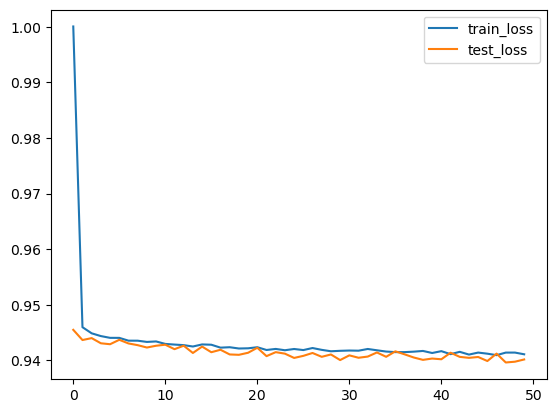

In [180]:
plt.plot( range(epochs), train_loss, label='train_loss')
plt.plot( range(epochs), test_loss, label='test_loss')
plt.legend()

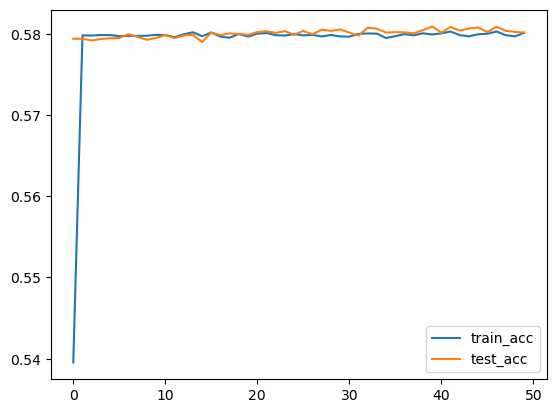

In [181]:
plt.plot( range(epochs), train_acc, label='train_acc')
plt.plot( range(epochs), test_acc, label='test_acc')
plt.legend()